## Imports

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from sklearn import metrics

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [4]:
df_lapil42 = pd.read_csv('data/LAPIL42_final_selection.csv')

In [5]:
df_lapil42.head()

,speed,hour,TV/h,Dayofweek,PL/h,Vitesse du vent moyen 10 mn,VL/h,Variation de pression en 3 heures,Etat du sol,Température,Température minimale du sol sur 12 heures,date,congestion+30min
0,87.0,0,434.0,0,141.0,2.700000,293.0,80.000000,1.000000,287.950000,286.450000,2019-09-23 00:00:00,0
1,87.0,0,434.0,0,141.0,2.672726,293.0,76.713049,0.997336,287.919104,286.424860,2019-09-23 00:06:00,1
2,87.0,0,520.0,0,170.0,2.642294,350.0,73.491523,0.995162,287.886406,286.398089,2019-09-23 00:12:00,0
3,87.0,0,520.0,0,170.0,2.608704,350.0,70.335422,0.993478,287.851905,286.369686,2019-09-23 00:18:00,0
4,86.0,0,390.0,0,120.0,2.571957,270.0,67.244747,0.992285,287.815602,286.339653,2019-09-23 00:24:00,0


## Echantillonage des données

In [42]:
def split_vals(df, n): 
    return df[:n].copy(), df[n:].copy()

In [43]:
Df = df_lapil42.drop(['congestion+30min', 'date'], axis = 1)
y = df_lapil42['congestion+30min']

In [44]:
n_total = len(df_lapil42)
n_test = 1500 #arbitrary
n_train = n_total - n_test

In [45]:
X_train, X_valid = split_vals(Df, n_train)
y_train, y_valid = split_vals(y, n_train)

print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of full training data points: X = (5220, 11), y = (5220,)
Number of validation data points: X = (1500, 11), y = (1500,)


## Premier modèle

In [10]:
def classifier_metrics (y_test, y_preds, average='weighted'):
    """Return Accuracy, Recall, Precision and F-1 score. 
    Average can take two arguments : macro or weighted """

    acc = metrics.accuracy_score(y_test, y_preds)
    rec = metrics.recall_score(y_test, y_preds, sample_weight = None)
    prc = metrics.precision_score(y_test, y_preds, sample_weight = None)
    f1  = metrics.f1_score(y_test, y_preds, sample_weight = None)

    print('Accuracy : {:.2f}%'.format(acc*100))
    print('Recall : {:.2f}%'.format(rec*100))
    print('Precision : {:.2f}%'.format(prc*100))
    print('F1-score : {:.2f}%'.format(f1*100))

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
first_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None,
    )    

In [14]:
first_model.fit(X_train, y_train)

KNeighborsClassifier()

In [15]:
classifier_metrics(y_train, first_model.predict(X_train))

Accuracy : 92.20%
Recall : 74.33%
Precision : 88.41%
F1-score : 80.76%


Ces premiers résultats sont prometteurs, chercons à les améliorer.

## Tuning des hyperparamètres

### "nombre de voisins"

In [16]:
def plt_f1(start, end, pas):
    f1_results = []
    f1_results_all = []
    
    for k in range(start, end, pas):
        model = KNeighborsClassifier(
            n_neighbors=k,
            weights='uniform',
            algorithm='auto',
            leaf_size=30,
            p=2,
            metric='minkowski',
            metric_params=None,
            n_jobs=-1,
        )    

        model.fit(X_train, y_train)
        mean_score = cross_val_score(model, X_train, y_train, scoring="f1", cv = 7).mean()

        f1_results.append(mean_score)
        
    plt.plot(f1_results)
    print([(k,v) for k,v in zip(f1_results, range(start,end,pas))])
    print('   ')

[(0.6366703531699905, 7), (0.6198357738659134, 8), (0.6394844315462613, 9), (0.6227347657523504, 10), (0.6295616705176343, 11), (0.6215526057573019, 12), (0.6324715454864089, 13)]
   


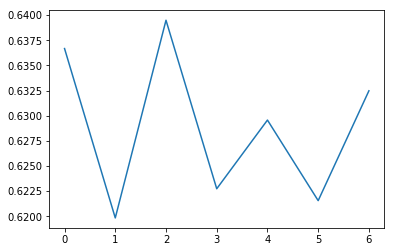

In [17]:
plt_f1(7,14,1)

Gardons 9 comme valeur.

### "weights"

In [18]:
model = KNeighborsClassifier(
    n_neighbors=9,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=-1,
    )    

model.fit(X_train, y_train)
mean_score = cross_val_score(model, X_train, y_train, scoring="f1", cv = 7).mean()
mean_score

0.6394844315462613

In [19]:
model = KNeighborsClassifier(
    n_neighbors=9,
    weights='distance',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=-1,
    )    

model.fit(X_train, y_train)
mean_score = cross_val_score(model, X_train, y_train, scoring="f1", cv = 7).mean()
mean_score

0.6389069307984895

Pas vraiment de différence notables, gardons la valeur par défaut.

### p in L_p distance

In [20]:
def plt_f1(start, end, pas):
    f1_results = []
    f1_results_all = []
    
    for k in range(start, end, pas):
        model = KNeighborsClassifier(
            n_neighbors=9,
            weights='uniform',
            algorithm='auto',
            leaf_size=30,
            p=k,
            metric='minkowski',
            metric_params=None,
            n_jobs=-1,
        )    

        model.fit(X_train, y_train)
        mean_score = cross_val_score(model, X_train, y_train, scoring="f1", cv = 7).mean()

        f1_results.append(mean_score)
        
    plt.plot(f1_results)
    print([(k,v) for k,v in zip(f1_results, range(start,end,pas))])
    print('   ')

[(0.6671689067414538, 1), (0.6394844315462613, 2), (0.6218686757138122, 3), (0.6145125501808052, 4), (0.6107406261101852, 5)]
   


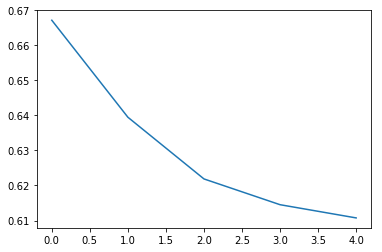

In [21]:
plt_f1(1,6,1)

Utilisons la distance Manhattan.

### leaf_size

In [22]:
def plt_f1(start, end, pas):
    f1_results = []
    f1_results_all = []
    
    for k in range(start, end, pas):
        model = KNeighborsClassifier(
            n_neighbors=9,
            weights='uniform',
            algorithm='auto',
            leaf_size=k,
            p=1,
            metric='manhattan',
            metric_params=None,
            n_jobs=-1,
        )    

        model.fit(X_train, y_train)
        mean_score = cross_val_score(model, X_train, y_train, scoring="f1", cv = 7).mean()

        f1_results.append(mean_score)
        
    plt.plot(f1_results)
    print([(k,v) for k,v in zip(f1_results, range(start,end,pas))])
    print('   ')

[(0.6671689067414538, 5), (0.6671689067414538, 10), (0.6671689067414538, 15), (0.6671689067414538, 20), (0.6671689067414538, 25), (0.6671689067414538, 30), (0.6671689067414538, 35), (0.6671689067414538, 40), (0.6671689067414538, 45), (0.6671689067414538, 50), (0.6671689067414538, 55)]
   


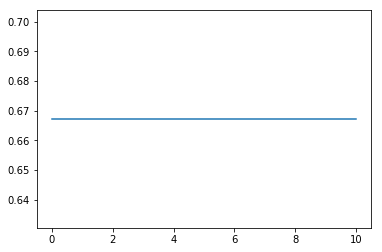

In [23]:
plt_f1(5, 60, 5)

Pas d'influence, gardons la valeur par défaut.

## Selections de variables explicatives

Les variables sont classés par odre d'importance au regard des résultats obtenus précédement. (Voir Notebook Sélection des colonnes par classification). Observons l'évolution des résultats lorsque nous ne gardons qu'un échantillon des variables explicatives.

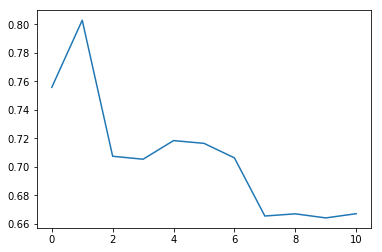

In [46]:
model = KNeighborsClassifier(
    n_neighbors=9,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=1,
    metric='manhattan',
    metric_params=None,
    n_jobs=-1,
    )

f1 = []

for k in range(1, X_train.shape[1]+1):
    col = X_train.columns.tolist()[:k]
    X = X_train[col]
    model.fit(X, y_train)
    mean_score = cross_val_score(model, X, y_train, scoring="f1", cv = 7).mean()
    f1.append(mean_score)
    
plt.plot(f1)

In [47]:
print([(k,v) for k,v in zip(f1, range(1,X_train.shape[1]+1))])

[(0.7557828217441483, 1), (0.802807245210225, 2), (0.7074386882228164, 3), (0.7053714071455051, 4), (0.7184297873085771, 5), (0.7164956642604573, 6), (0.7063241212677064, 7), (0.6655428958213149, 8), (0.667084178358647, 9), (0.6642141290204767, 10), (0.6671689067414538, 11)]


En gardant uniquement les variables speed et hour nous améliorons grandement nos résultats. Essayons d'affiner les hyperparamètres pour cette nouvelle configuration :

### Nombre de voisins

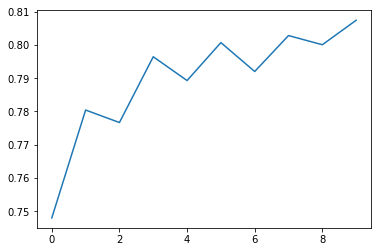

In [48]:
f1 = []

X = X_train[['speed', 'hour']]
for k in range(2,12,1):
    model = KNeighborsClassifier(
        n_neighbors=k,
        weights='uniform',
        algorithm='auto',
        leaf_size=30,
        p=1,
        metric='manhattan',
        metric_params=None,
        n_jobs=-1,
    )

    model.fit(X, y_train)
    mean_score = cross_val_score(model, X, y_train, scoring="f1", cv = 7).mean()
    f1.append(mean_score)
    
plt.plot(f1)

In [49]:
print([(k,v) for k,v in zip(f1, range(2,12))])

[(0.7480169574139073, 2), (0.7804332197868137, 3), (0.776675937594738, 4), (0.7964385183841516, 5), (0.7892898970605157, 6), (0.8006899100569583, 7), (0.7920109825329805, 8), (0.802807245210225, 9), (0.8000505583031753, 10), (0.8074099437742953, 11)]


Gardons 9 'voisins'

### Weight

In [50]:
model = KNeighborsClassifier(
    n_neighbors=9,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=1,
    metric='manhattan',
    metric_params=None,
    n_jobs=-1,
    )    

model.fit(X, y_train)
mean_score = cross_val_score(model, X, y_train, scoring="f1", cv = 7).mean()
mean_score

0.802807245210225

In [51]:
model = KNeighborsClassifier(
    n_neighbors=9,
    weights='distance',
    algorithm='auto',
    leaf_size=30,
    p=1,
    metric='manhattan',
    metric_params=None,
    n_jobs=-1,
    )    

model.fit(X, y_train)
mean_score = cross_val_score(model, X, y_train, scoring="f1", cv = 7).mean()
mean_score

0.7884210688100967

Gardons le weight 'uniform'.

### Leaf size

In [52]:
def plt_f1(start, end, pas):
    f1_results = []
    f1_results_all = []
    
    for k in range(start, end, pas):
        model = KNeighborsClassifier(
            n_neighbors=9,
            weights='uniform',
            algorithm='auto',
            leaf_size=k,
            p=1,
            metric='manhattan',
            metric_params=None,
            n_jobs=-1,
        )    

        model.fit(X, y_train)
        mean_score = cross_val_score(model, X, y_train, scoring="f1", cv = 7).mean()

        f1_results.append(mean_score)
        
    plt.plot(f1_results)
    print([(k,v) for k,v in zip(f1_results, range(start,end,pas))])
    print('   ')

[(0.806950799548488, 5), (0.802807245210225, 25), (0.7994732303741632, 45), (0.7994732303741632, 65), (0.8031626912084384, 85), (0.8031626912084384, 105), (0.8031626912084384, 125), (0.8051852225868613, 145), (0.8051852225868613, 165), (0.8051852225868613, 185), (0.8051852225868613, 205), (0.8051852225868613, 225), (0.8051852225868613, 245), (0.8051852225868613, 265), (0.8097887936287347, 285), (0.8097887936287347, 305), (0.8097887936287347, 325), (0.8097887936287347, 345), (0.8097887936287347, 365), (0.8097887936287347, 385), (0.8097887936287347, 405), (0.8097887936287347, 425), (0.8097887936287347, 445), (0.8097887936287347, 465), (0.8097887936287347, 485)]
   


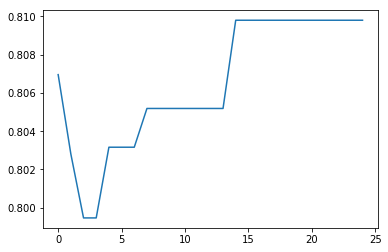

In [53]:
plt_f1(5,500,20)

Les variations sont très faibles, gardons la valeur par défaut.

## Conclusion

Le meilleur modèle est celui avec les hyperparamètres ci-dessous et seulement deux variables explcatives : "speed" et "hour"

In [44]:
model = KNeighborsClassifier(
    n_neighbors=9,
    weights='distance',
    algorithm='auto',
    leaf_size=30,
    p=1,
    metric='manhattan',
    metric_params=None,
    n_jobs=-1,
    )    

In [55]:
X.columns.tolist()

['speed', 'hour']